# Prolexitim NLP Analytics 
## TAS-20 & Text Data. Predictive Analysis
### Single node Machine Learning - Regression
<hr>
<b>Dataset from Prolexitim TAS-20 Spain instrument and Prolexitim NLP.</b><br>
<b>No Text Analytics included here. Using TAS and NLP APIs scores.</b>
<hr>
May 2019.<br> Prolexitim normalized dataset version 1.2 (MPGS-TFM-Submission).<br> 
Raúl Arrabales Moreno (Psicobótica / Serendeepia Research)<br>
<a target="_blank" href="http://www.conscious-robots.com/">http://www.conscious-robots.com/</a> <br>
<hr>

## This notebook contains: 

- TAS-20 + NLP Dataset loading. 
- Linear Regression for TAS-20 Score based on sentiment scores.
- One HOT Encoding for TAT cards (not used in regression). 
- Linear Regression for TAS-20 score. 
- MSE, RMSE Calculation. 
- Regression Plots. 
- 3-Degree Polynomial Regression for TAS-20 score.
- Exploration of regression for TAS-20 subscales (F1, F2, F3)

### Loading TAS Sentiment dataset

In [1]:
import pandas as pd 
from scipy import stats
import seaborn as sns

# Load nomalized dataset (no text, only TAS and NLP scores)
tasnlp_dataset_path = "D:\\Dropbox-Array2001\\Dropbox\\UNI\\MPGS\\2_TFM\\Datos\\prolexitim-sentiment-n-1.2.csv"

tasnlp_df = pd.read_csv(tasnlp_dataset_path,header=0,delimiter="\t")

In [2]:
tasnlp_df.head()

,code,TAS20,F1,F2,F3,alex-a,alex-b,card,G-score,G-magnitude,...,nlu-joy,nlu-anger,nlu-fear,nlu-disgust,nlu-sadness,es-len,G-score-n,Azure-TA-n,nlu-sentiment-n,mean-sentiment
0,b7adde8a9eec8ce92b5ee0507ce054a4,39.0,12.0,14.0,13.0,NoAlex,NoAlex,13V,-0.2,0.2,...,0.317920,0.143086,0.098997,0.422023,0.173421,115,0.388889,0.62,0.179832,0.396240
1,b7adde8a9eec8ce92b5ee0507ce054a4,39.0,12.0,14.0,13.0,NoAlex,NoAlex,18NM,-0.5,0.5,...,0.285100,0.168727,0.109176,0.057098,0.362623,110,0.222222,0.41,0.503295,0.378506
2,b7adde8a9eec8ce92b5ee0507ce054a4,39.0,12.0,14.0,13.0,NoAlex,NoAlex,12VN,0.0,1.2,...,0.039779,0.205065,0.481812,0.244164,0.164005,93,0.500000,0.63,0.637584,0.589195
3,76ef63369f7d5b6597a543017e1ef578,63.0,23.0,21.0,19.0,Alex,Alex,12VN,0.0,0.1,...,0.208997,0.007244,0.190991,0.008434,0.698307,255,0.500000,0.89,0.324648,0.571549
4,76ef63369f7d5b6597a543017e1ef578,63.0,23.0,21.0,19.0,Alex,Alex,10,0.3,0.1,...,0.367801,0.063256,0.103351,0.095947,0.469062,184,0.666667,0.24,0.224342,0.377003


## Linear Regression for TAS20 score

In [142]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np

In [143]:
# Split train and test
train_df, test_df = train_test_split(tasnlp_df, test_size=0.2)
print(len(train_df))
print(len(test_df))

256
64


### One HOT Enconding for train/test dataframes - Categorical variables

In [68]:
# One HOT encoding for TAT card variable with pandas

# Categorical columns
cat_columns = ["card"]

df_processed = pd.get_dummies(train_df, prefix_sep="_HOT_",
                              columns=cat_columns)

In [54]:
# f_processed.dtypes

In [69]:
cat_dummies = [col for col in df_processed 
               if "_HOT_" in col and col.split("_HOT_")[0] in cat_columns]

In [70]:
cat_dummies

['card_HOT_1',
 'card_HOT_10',
 'card_HOT_11',
 'card_HOT_12VN',
 'card_HOT_13HM',
 'card_HOT_13N',
 'card_HOT_13V',
 'card_HOT_18NM',
 'card_HOT_3VH',
 'card_HOT_7VH',
 'card_HOT_9BM',
 'card_HOT_9VH']

In [71]:
processed_columns = list(df_processed.columns[:])

In [59]:
# processed_columns

In [72]:
df_test_processed = pd.get_dummies(test_df, prefix_sep="_HOT_", 
                                   columns=cat_columns)

In [74]:
# df_test_processed

In [75]:
# Remove additional columns from test set
for col in df_test_processed.columns:
    if ("_HOT_" in col) and (col.split("_HOT_")[0] in cat_columns) and col not in cat_dummies:
        print("Removing additional feature {}".format(col))
        df_test_processed.drop(col, axis=1, inplace=True)

In [76]:
# Now we need to add the missing columns. 
# We can set all missing columns to a vector of 0s
# since those values did not appear in the test data.
for col in cat_dummies:
    if col not in df_test_processed.columns:
        print("Adding missing feature {}".format(col))
        df_test_processed[col] = 0

Adding missing feature card_HOT_9BM


In [77]:
# Rearrange column order
df_test_processed = df_test_processed[processed_columns]

### Linear Regression (using One HOT enconding for cards)

Y = f(X1, X2, X3, X4)
<br>  
- Y: TAS-20
- X1: Mean Sentiment
- X2: Length of text
- X3: GC Sentiment Magnitude
- X4-16: TAT Card Used
<br>


Datasets split in train/test


In [167]:
# Predict Y as a function of X -->  Y = f(X)

Y_train = df_processed["TAS20"]

# list of X variables
Xlist = ["mean-sentiment", "es-len", "G-magnitude"] + cat_dummies
X_train = df_processed[Xlist]

In [168]:
X_train.head()

,mean-sentiment,es-len,G-magnitude,card_HOT_1,card_HOT_10,card_HOT_11,card_HOT_12VN,card_HOT_13HM,card_HOT_13N,card_HOT_13V,card_HOT_18NM,card_HOT_3VH,card_HOT_7VH,card_HOT_9BM,card_HOT_9VH
154,0.790005,414,1.2,1,0,0,0,0,0,0,0,0,0,0,0
292,0.486167,174,0.5,0,0,0,0,1,0,0,0,0,0,0,0
262,0.369516,668,2.5,0,0,0,0,0,0,0,0,0,0,0,1
249,0.551280,138,0.2,1,0,0,0,0,0,0,0,0,0,0,0
230,0.334819,171,0.4,0,0,0,0,0,0,0,0,0,0,0,1


In [169]:
# Create a train the model (OLS - Ordinary Least Squares)
model = sm.OLS(Y_train, X_train).fit()

In [170]:
# Testing the model
X_test = df_test_processed[Xlist]
predictions = model.predict(X_test)

In [171]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TAS20   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.191
Date:                Sun, 12 May 2019   Prob (F-statistic):              0.283
Time:                        12:39:03   Log-Likelihood:                -941.88
No. Observations:                 256   AIC:                             1914.
Df Residuals:                     241   BIC:                             1967.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
mean-sentiment    -1.5303      3.649     -0.419      0.675      -8.718       5.658
es-len            -0.0036      0.006     -0.637      0.525      -0.015       0.008
G-magnitude       -1.2589      1.294     -0.973      0.332      -3.808       1.290
card_HOT_1        48.6788      2.223     21.901      0.000      44.300      53.057
card_HOT_10       44.3398      5.047      8.786      0.000      34.398      54.281
card_HOT_11       48.5747      2.668     18.209      0.000      43.320      53.830
card_HOT_12VN     49.3321      4.581     10.770      0.000      40.309      58.355
card_HOT_13HM     47.6035      1.992     23.894      0.000      43.679      51.528
card_HOT_13N      36.4861      6.071      6.010      0.000      24.526      48.446
card_HOT_13V      41.4697      5.167      8.027      0.000      31.292      51.647
card_HOT_18NM     38.5653      5.816      6.631      0.000      27.108      50.022
card_HOT_3VH      42.6774      5.019      8.503      0.000      32.791      52.564
card_HOT_7VH      41.9707      6.217      6.750      0.000      29.723      54.218
card_HOT_9BM      37.1927     10.138      3.669      0.000      17.223      57.162
card_HOT_9VH      49.0302      2.463     19.904      0.000      44.178      53.883
==============================================================================
Omnibus:                       21.110   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.372
Skew:                           0.754   Prob(JB):                     5.10e-06
Kurtosis:                       3.105   Cond. No.                     3.99e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Linear Regression for TAS-20

Y = f(X1, X2, X3)
<br>  
- Y: TAS-20
- X1: Mean Sentiment
- X2: Length of text
- X3: GC Sentiment Magnitude
<br>


In [192]:
# Using the whole dataset
Y_train = tasnlp_df["TAS20"]
X_train = tasnlp_df[["mean-sentiment", "es-len", "G-magnitude"]]

In [193]:
# Create a train the model (OLS - Ordinary Least Squares)
model = sm.OLS(Y_train, X_train).fit()

In [203]:
# Testing the model
X_test = tasnlp_df[["mean-sentiment", "es-len", "G-magnitude"]]
predictions = model.predict(X_test)

In [204]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TAS20   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     509.1
Date:                Sun, 12 May 2019   Prob (F-statistic):          7.87e-121
Time:                        12:58:17   Log-Likelihood:                -1401.6
No. Observations:                 320   AIC:                             2809.
Df Residuals:                     317   BIC:                             2821.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
mean-sentiment    64.8164      3.163     20.491      0.000      58.593      71.040
es-len             0.0459      0.009      4.841      0.000       0.027       0.065
G-magnitude        0.7479      2.184      0.342      0.732      -3.549       5.045
==============================================================================
Omnibus:                        2.975   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                2.285
Skew:                          -0.046   Prob(JB):                        0.319
Kurtosis:                       2.596   Cond. No.                         707.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Calculate MSE, RMSE

In [205]:
# Add predictions to the original dataframe
# tasnlp_df.insert(loc=len(tasnlp_df.columns), column='TAS20-P', value=0.0)

In [206]:
for index, row in tasnlp_df.iterrows():
    TAS20P = row["mean-sentiment"]*64.8381 + row["es-len"]*0.0424 + row["G-magnitude"]*2.0374
    # print("TAS-20 Prediction: " + str(TAS20P) +". Real TAS-20: " + str(row["TAS20"]))
    tasnlp_df.at[index, "TAS20-P"] = TAS20P

In [207]:
tasnlp_df[["TAS20", "TAS20-P"]].head()

,TAS20,TAS20-P
0,39.0,30.974948
1,39.0,30.224287
2,39.0,44.590348
3,63.0,48.073905
4,63.0,32.449495


In [208]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [209]:
def rme(predictions, targets):
    return ((predictions - targets) ** 2).mean()

In [210]:
print("RMSE = " + str( rmse(tasnlp_df["TAS20-P"], tasnlp_df["TAS20"]) ))
print("RME = " + str( rme(tasnlp_df["TAS20-P"], tasnlp_df["TAS20"]) ))

RMSE = 19.333870340100045
RME = 373.79854232780025


In [211]:
from sklearn.metrics import mean_squared_error
mean_squared_error(tasnlp_df["TAS20"], tasnlp_df["TAS20-P"])

373.7985423278004

### Regression Plots

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt

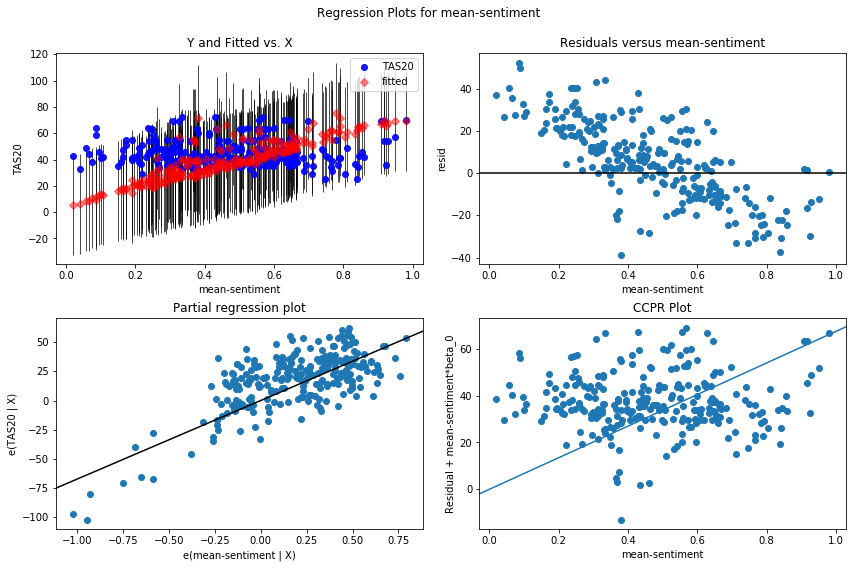

In [133]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, "mean-sentiment", fig=fig)

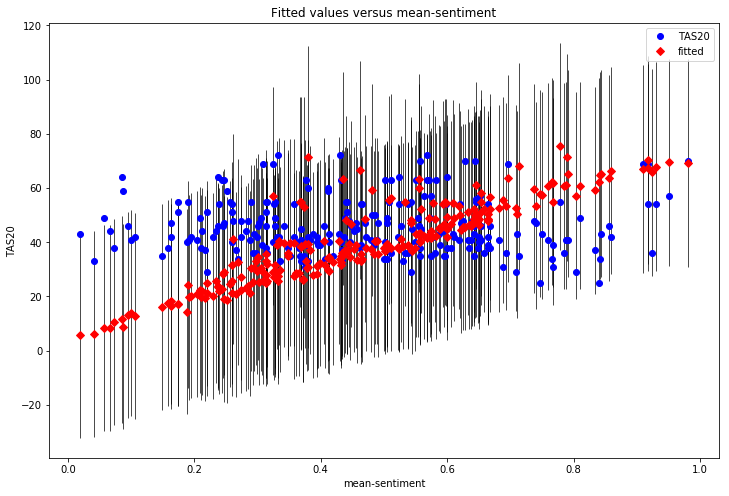

In [135]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(model, "mean-sentiment", ax=ax)

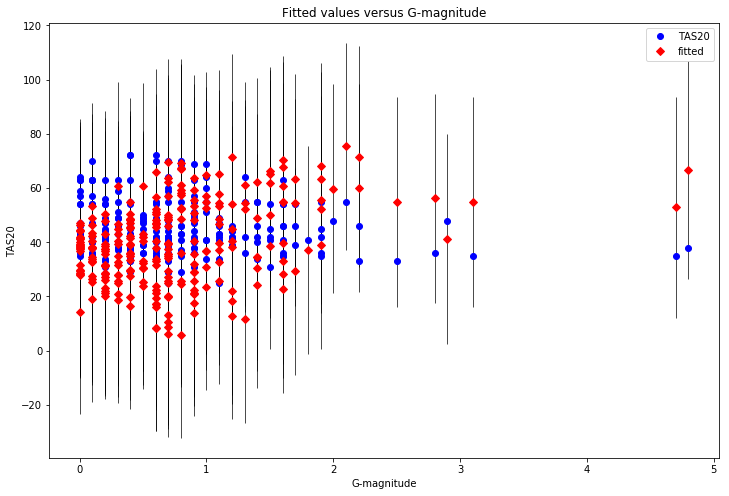

In [136]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(model, "G-magnitude", ax=ax)

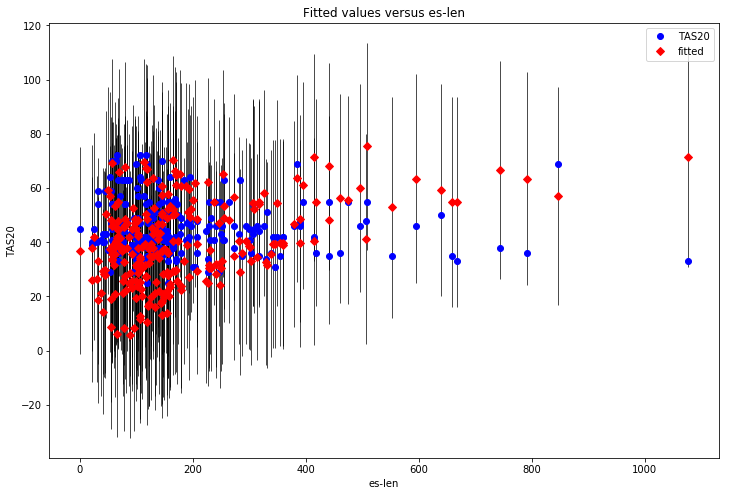

In [137]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(model, "es-len", ax=ax)

### Partial Regression Plots

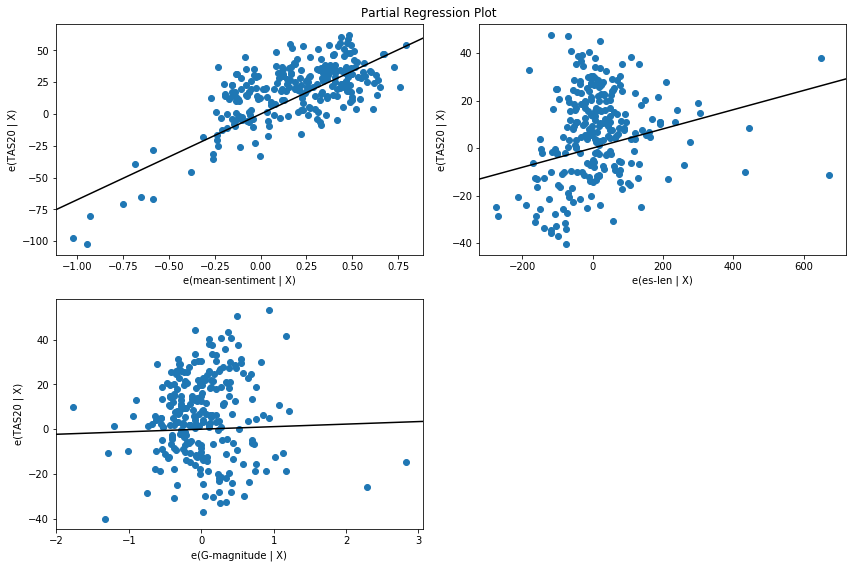

In [120]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

### Influence Plot

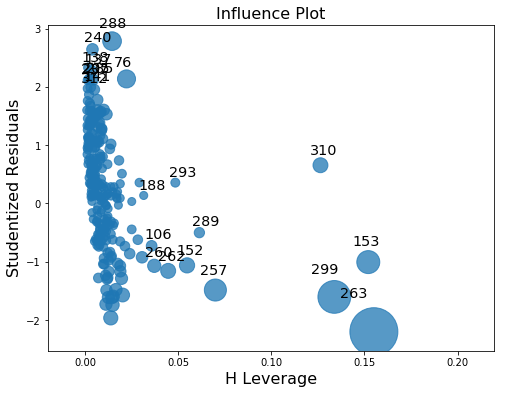

In [130]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.influence_plot(model, ax=ax)

## Polynomial Regression for TAS20 score

In [185]:
import seaborn as sns
sns.set_style('whitegrid')

In [186]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [220]:
X = tasnlp_df["mean-sentiment"]
y = tasnlp_df["TAS20"]

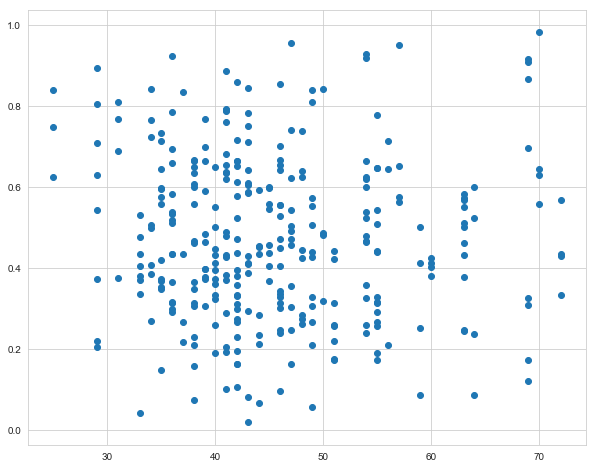

In [221]:
plt.figure(figsize=(10,8))
plt.scatter(y, X)

0.0007923283030878414


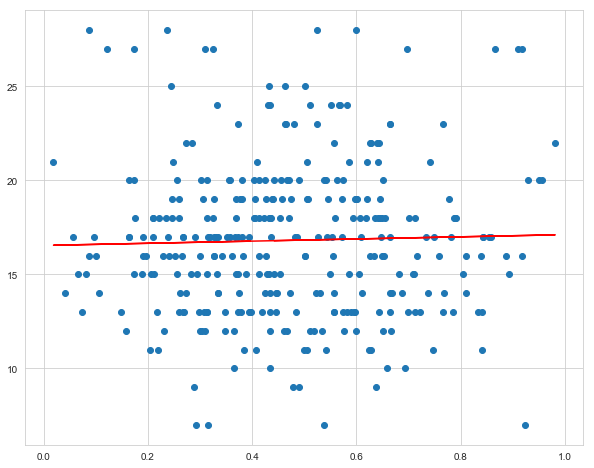

In [242]:
lin_reg = LinearRegression()
lin_reg.fit(X.values.reshape(-1, 1), y)
model_pred = lin_reg.predict(X.values.reshape(-1,1))
plt.figure(figsize=(10,8));
plt.scatter(X, y);
plt.plot(X, model_pred, color='r');
print(r2_score(y, model_pred))

In [226]:
# Really bad results, let's go polynomial
from sklearn.preprocessing import PolynomialFeatures

# Degree 2, parabolic function
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X.values.reshape(-1, 1))

0.003854274875205288


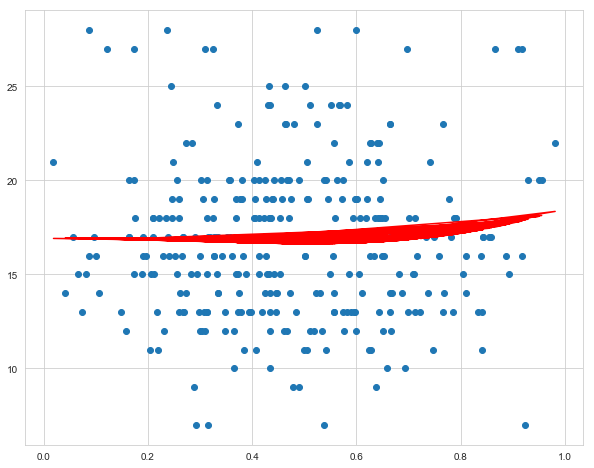

In [243]:
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y.values.reshape(-1, 1))
y_pred = lin_reg_2.predict(X_poly)
plt.figure(figsize=(10,8));
plt.scatter(X, y);
plt.plot(X, y_pred, color='r');
print(r2_score(y, y_pred))

In [237]:
# Degree 3, 
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X.values.reshape(-1, 1))

0.003854274875205288


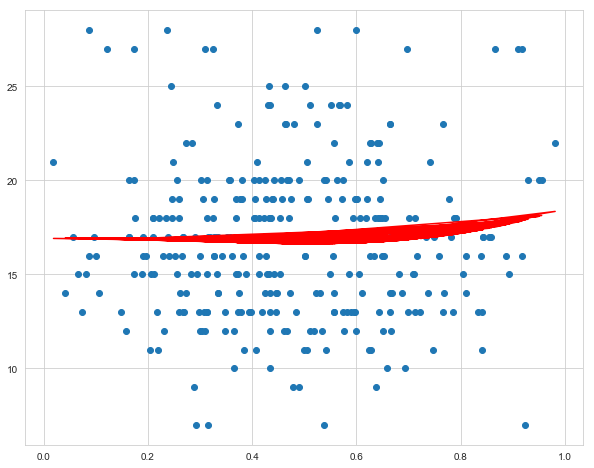

In [246]:
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y.values.reshape(-1, 1))
y_pred = lin_reg_2.predict(X_poly)
plt.figure(figsize=(10,8));
plt.scatter(X, y);
plt.plot(X, y_pred, color='r');
print(r2_score(y, y_pred))

### Linear Regression for TAS-20 subscales (F1, F2, F3)

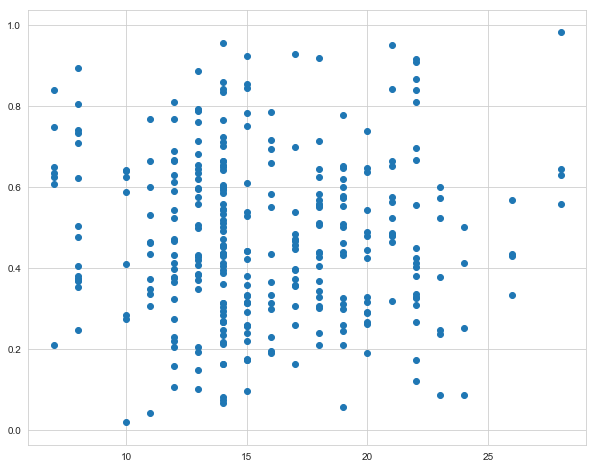

In [239]:
X = tasnlp_df["mean-sentiment"]
y = tasnlp_df["F1"]
plt.figure(figsize=(10,8))
plt.scatter(y, X)

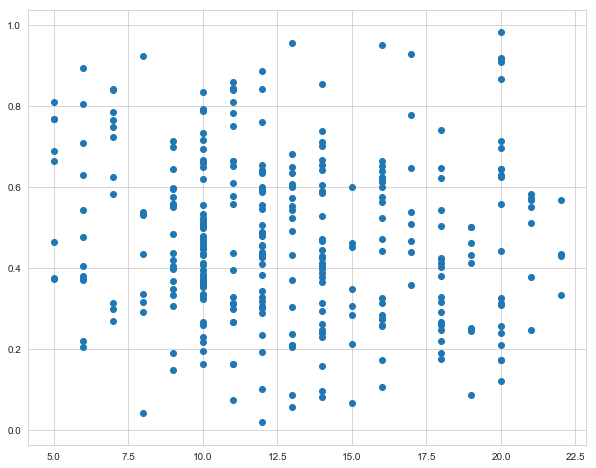

In [240]:
X = tasnlp_df["mean-sentiment"]
y = tasnlp_df["F2"]
plt.figure(figsize=(10,8))
plt.scatter(y, X)

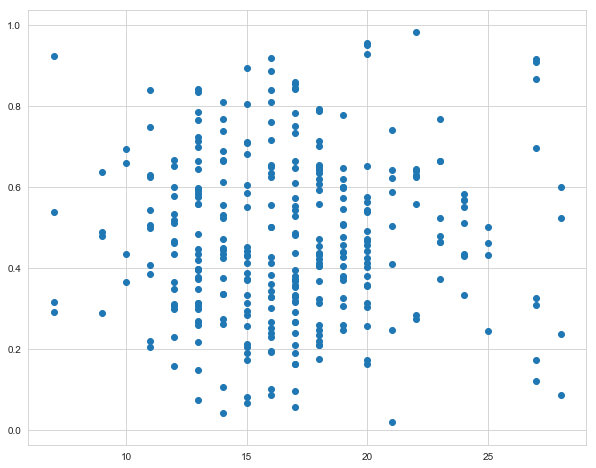

In [241]:
X = tasnlp_df["mean-sentiment"]
y = tasnlp_df["F3"]
plt.figure(figsize=(10,8))
plt.scatter(y, X)

In [247]:
Y_train = tasnlp_df["F1"]
X_train = tasnlp_df[["mean-sentiment", "es-len", "G-magnitude"]]
model = sm.OLS(Y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     F1   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     444.9
Date:                Sun, 12 May 2019   Prob (F-statistic):          3.04e-113
Time:                        13:15:51   Log-Likelihood:                -1083.0
No. Observations:                 320   AIC:                             2172.
Df Residuals:                     317   BIC:                             2183.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
mean-sentiment    22.3993      1.169     19.165      0.000      20.100      24.699
es-len             0.0169      0.004      4.830      0.000       0.010       0.024
G-magnitude       -0.0102      0.807     -0.013      0.990      -1.598       1.578
==============================================================================
Omnibus:                        1.550   Durbin-Watson:                   0.978
Prob(Omnibus):                  0.461   Jarque-Bera (JB):                1.548
Skew:                          -0.101   Prob(JB):                        0.461
Kurtosis:                       2.725   Cond. No.                         707.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [248]:
Y_train = tasnlp_df["F2"]
X_train = tasnlp_df[["mean-sentiment", "es-len", "G-magnitude"]]
model = sm.OLS(Y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     F2   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     352.2
Date:                Sun, 12 May 2019   Prob (F-statistic):          1.47e-100
Time:                        13:16:13   Log-Likelihood:                -1053.2
No. Observations:                 320   AIC:                             2112.
Df Residuals:                     317   BIC:                             2124.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
mean-sentiment    18.2900      1.065     17.178      0.000      16.195      20.385
es-len             0.0117      0.003      3.664      0.000       0.005       0.018
G-magnitude        0.4012      0.735      0.546      0.586      -1.045       1.848
==============================================================================
Omnibus:                        4.493   Durbin-Watson:                   0.890
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                3.048
Skew:                          -0.045   Prob(JB):                        0.218
Kurtosis:                       2.530   Cond. No.                         707.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [249]:
Y_train = tasnlp_df["F3"]
X_train = tasnlp_df[["mean-sentiment", "es-len", "G-magnitude"]]
model = sm.OLS(Y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     F3   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     521.0
Date:                Sun, 12 May 2019   Prob (F-statistic):          3.83e-122
Time:                        13:16:19   Log-Likelihood:                -1081.7
No. Observations:                 320   AIC:                             2169.
Df Residuals:                     317   BIC:                             2181.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
mean-sentiment    23.8682      1.164     20.510      0.000      21.579      26.158
es-len             0.0174      0.003      4.977      0.000       0.011       0.024
G-magnitude        0.3688      0.804      0.459      0.647      -1.212       1.950
==============================================================================
Omnibus:                        0.801   Durbin-Watson:                   1.136
Prob(Omnibus):                  0.670   Jarque-Bera (JB):                0.915
Skew:                           0.086   Prob(JB):                        0.633
Kurtosis:                       2.802   Cond. No.                         707.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""